 MtM simulation and added VaR calculation, stress testing, GM@R estimation, and some basic visualization.

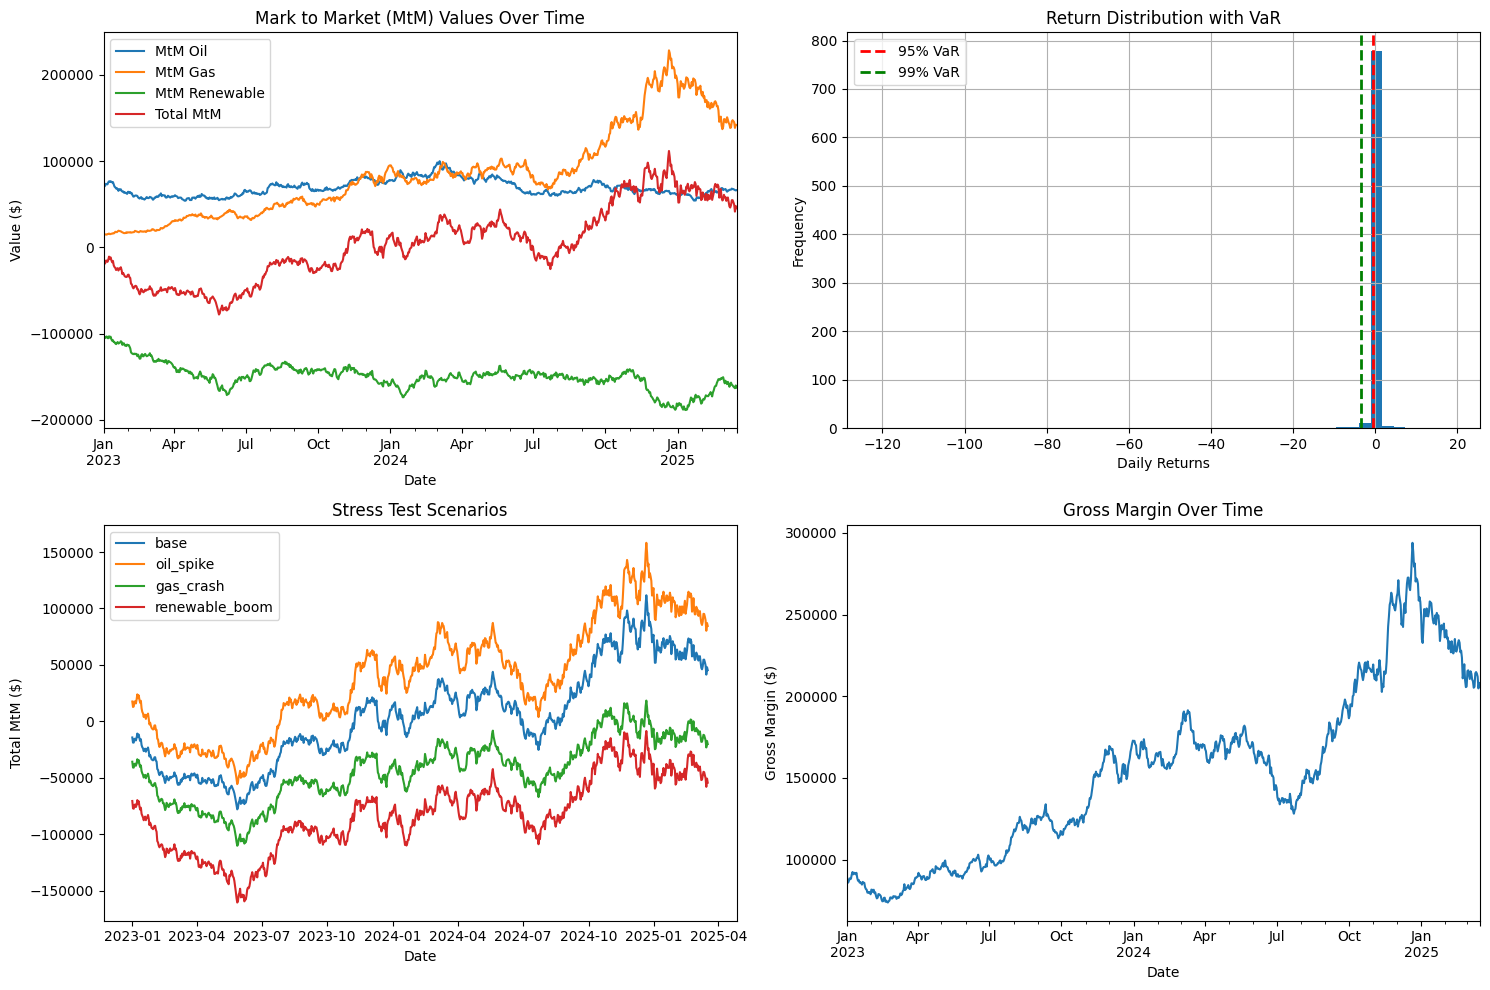

95% VaR: -52.26%
99% VaR: -354.13%
95% GM@R: -3.05%

Stress Test Results (Final Total MtM):
base: $45,343.26
oil_spike: $84,520.49
gas_crash: $-20,133.56
renewable_boom: $-54,317.87


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
start_date = "2023-01-01"
end_date = "2025-03-17"
dates = pd.date_range(start=start_date, end=end_date, freq="D")
n = len(dates)

# Simulate commodity prices
def simulate_prices(initial_price, volatility, trend, n):
    return np.exp(np.cumsum(np.random.normal(trend, volatility, n))) * initial_price

oil_prices = simulate_prices(70, 0.02, 0.0001, n)
gas_prices = simulate_prices(3, 0.03, 0.0002, n)
renewable_prices = simulate_prices(50, 0.015, 0.0003, n)

# Portfolio positions
positions = {'oil': 1000, 'gas': 5000, 'renewable': -2000}

# Calculate MtM values
mtm_oil = oil_prices * positions['oil']
mtm_gas = gas_prices * positions['gas']
mtm_renewable = renewable_prices * positions['renewable']
total_mtm = mtm_oil + mtm_gas + mtm_renewable

# Create DataFrame
df = pd.DataFrame({
    "Date": dates,
    "Oil Price": oil_prices,
    "Gas Price": gas_prices,
    "Renewable Price": renewable_prices,
    "MtM Oil": mtm_oil,
    "MtM Gas": mtm_gas,
    "MtM Renewable": mtm_renewable,
    "Total MtM": total_mtm
})
df.set_index("Date", inplace=True)

# VaR Calculation
def calculate_var(returns, confidence_level):
    return np.percentile(returns, 100 - confidence_level)

returns = df['Total MtM'].pct_change().dropna()
var_95 = calculate_var(returns, 95)
var_99 = calculate_var(returns, 99)

# Stress Testing
def stress_test(df, scenario):
    stressed_df = df.copy()
    for commodity, change in scenario.items():
        col_name = f"{commodity.capitalize()} Price"
        stressed_df[col_name] *= (1 + change)
        stressed_df[f"MtM {commodity.capitalize()}"] = stressed_df[col_name] * positions[commodity.lower()]
    stressed_df["Total MtM"] = stressed_df[[f"MtM {c.capitalize()}" for c in positions.keys()]].sum(axis=1)
    return stressed_df

# Define stress scenarios
scenarios = {
    "base": {"oil": 0, "gas": 0, "renewable": 0},
    "oil_spike": {"oil": 0.5, "gas": 0.1, "renewable": 0.05},
    "gas_crash": {"oil": -0.1, "gas": -0.3, "renewable": 0.1},
    "renewable_boom": {"oil": -0.2, "gas": -0.15, "renewable": 0.4}
}

# Run stress tests
stress_results = {name: stress_test(df, scenario) for name, scenario in scenarios.items()}

# GM@R Calculation (simplified)
def calculate_gmar(df, confidence_level):
    total_revenue = (df['Oil Price'] * positions['oil'] +
                     df['Gas Price'] * positions['gas'] +
                     df['Renewable Price'] * abs(positions['renewable']))
    total_cost = df['Renewable Price'] * abs(positions['renewable'])  # Assuming renewable is the only cost
    gross_margin = total_revenue - total_cost
    gm_returns = gross_margin.pct_change().dropna()
    return np.percentile(gm_returns, 100 - confidence_level)

gmar_95 = calculate_gmar(df, 95)

# Visualization
plt.figure(figsize=(15, 10))

# MtM Plot
plt.subplot(2, 2, 1)
df[['MtM Oil', 'MtM Gas', 'MtM Renewable', 'Total MtM']].plot(ax=plt.gca())
plt.title('Mark to Market (MtM) Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value ($)')

# VaR Plot
plt.subplot(2, 2, 2)
returns.hist(bins=50, ax=plt.gca())
plt.axvline(var_95, color='r', linestyle='dashed', linewidth=2)
plt.axvline(var_99, color='g', linestyle='dashed', linewidth=2)
plt.title('Return Distribution with VaR')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend(['95% VaR', '99% VaR'])

# Stress Test Plot
plt.subplot(2, 2, 3)
for name, result in stress_results.items():
    plt.plot(result.index, result['Total MtM'], label=name)
plt.title('Stress Test Scenarios')
plt.xlabel('Date')
plt.ylabel('Total MtM ($)')
plt.legend()

# GM@R Plot
plt.subplot(2, 2, 4)
gross_margin = (df['Oil Price'] * positions['oil'] +
                df['Gas Price'] * positions['gas'] +
                df['Renewable Price'] * abs(positions['renewable']) -
                df['Renewable Price'] * abs(positions['renewable']))
gross_margin.plot(ax=plt.gca())
plt.title('Gross Margin Over Time')
plt.xlabel('Date')
plt.ylabel('Gross Margin ($)')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"95% VaR: {var_95:.2%}")
print(f"99% VaR: {var_99:.2%}")
print(f"95% GM@R: {gmar_95:.2%}")
print("\nStress Test Results (Final Total MtM):")
for name, result in stress_results.items():
    print(f"{name}: ${result['Total MtM'].iloc[-1]:,.2f}")


# Comprehensive Energy Portfolio Analysis

This script covers:

## 1. Mark to Market (MtM) Calculation
- Computes daily MtM values for a portfolio of energy commodities (oil, gas, renewables)

## 2. Value at Risk (VaR) Calculation
- Calculates VaR at 95% and 99% confidence levels
- Provides insight into potential portfolio losses

## 3. Stress Testing
- Implements various scenarios to assess portfolio performance under different market conditions
- Scenarios include base case, oil price spike, gas price crash, and renewable energy boom

## 4. Gross Margin at Risk (GM@R) Calculation
- Simplified version to estimate potential impact on gross margins

## 5. Visualization
- Plots MtM values over time
- Displays VaR on return distribution
- Shows stress test results across scenarios
- Illustrates gross margin trends

## 6. Summary Statistics
- Outputs key risk metrics including VaR, GM@R, and stress test results

This analysis demonstrates advanced risk management techniques for energy portfolios using Python.
